### 일본 온라인쇼핑몰 데이터, price(예측 target)예측

In [1]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)


Bad key "axes_unicode_minus" on line 3 in
/home/jovyan/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
mercari_df.info()
# null값 확인
# brand_name category_name item_description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


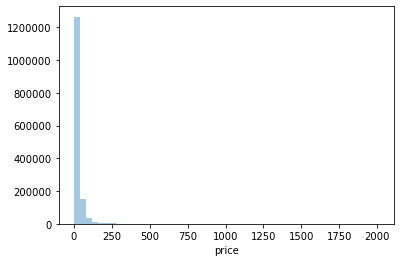

In [3]:
# target price 데이터분포도 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

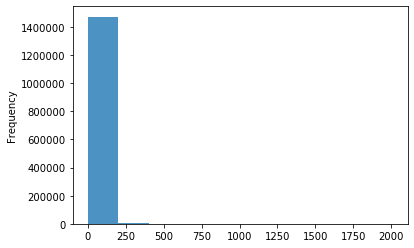

In [8]:
#y_train_df.plot(kind='bar', alpha=0.5, figsize=(6,4)) # 실행중 뻑
y_train_df.plot(kind='hist', alpha=0.8, figsize=(6,4)) # alpha 색깔농도가 달라짐
plt.show()

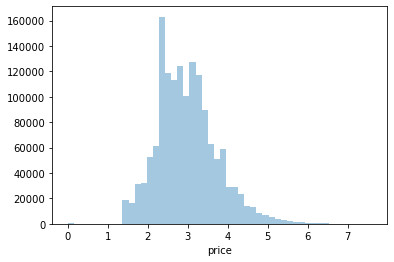

In [9]:
# 회귀에서 target값의 정규분포는 매우 중요 => 로그변환 정규분포
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)


In [10]:
# 원본 DataFrame에서 로그 정규분포화
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [11]:
# 다른 피처 column의 값 분포 확인
# shipping 배송비 여부, item_condition_id 정보 제공치 않았음 No description yet값이 있음
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [12]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [13]:
# category_name 칼럼 men/Tops/T-shirts 대중소 분류 가능
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())


대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871
